In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


## **Memuat Dataset**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Belajar Machine Learning Pemula/Churn predict/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# **Exploratory Data Analysis (EDA)**

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
print(f"Jumlah nilai kosong (NaN) di TotalCharges: {df['TotalCharges'].isnull().sum()}")

nan_total_charges_rows = df[df['TotalCharges'].isnull()]

print("Baris data di mana 'TotalCharges' adalah NaN:")
print(nan_total_charges_rows)

Jumlah nilai kosong (NaN) di TotalCharges: 11
Baris data di mana 'TotalCharges' adalah NaN:
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSec

In [6]:
# Hitung median terlebih dahulu (lebih bersih)
median_total_charges = df['TotalCharges'].median()

# Gunakan fillna tanpa 'inplace' dan tugaskan kembali
df['TotalCharges'] = df['TotalCharges'].fillna(median_total_charges)

In [7]:
print("\nVerifikasi tipe data setelah diubah:")
print(df[['tenure', 'TotalCharges']].info())


Verifikasi tipe data setelah diubah:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tenure        7043 non-null   int64  
 1   TotalCharges  7043 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 110.2 KB
None


In [8]:
print(df[df['tenure'] == 0][['tenure', 'TotalCharges']])

      tenure  TotalCharges
488        0      1397.475
753        0      1397.475
936        0      1397.475
1082       0      1397.475
1340       0      1397.475
3331       0      1397.475
3826       0      1397.475
4380       0      1397.475
5218       0      1397.475
6670       0      1397.475
6754       0      1397.475


In [9]:
duplicates = df.duplicated()
print(f'jumlah data duplikat: {duplicates.sum()}')

jumlah data duplikat: 0


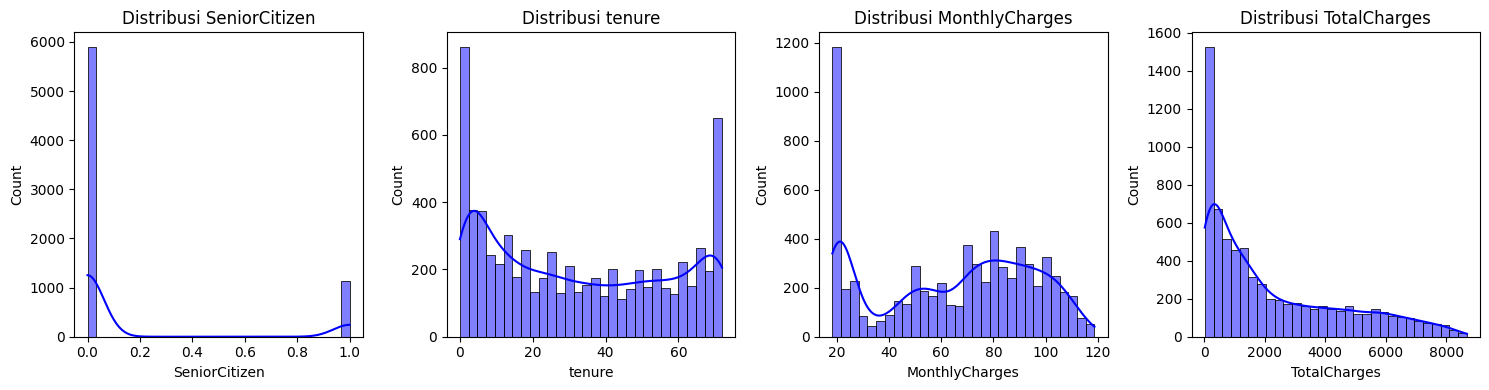

In [10]:
# Pilih hanya fitur numerik
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

# Tentukan jumlah kolom dan baris subplot secara otomatis
num_cols = 4
num_rows = -(-len(numeric_features) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Flatten axes untuk memudahkan iterasi jika lebih dari 1 baris
axes = axes.flatten()

for i, column in enumerate(numeric_features):
    sns.histplot(df[column], bins=30, kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribusi {column}')

# Hide subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
df = df.drop(['customerID'], axis=1)

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def advance_preprocessing(df):
  df_processed = df.copy()

  # Encode variable biner
  binary_mapping = {'Yes': 1, 'No': 0}
  binary_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

  for feature in binary_features:
    df_processed[feature] = df_processed[feature].map(binary_mapping)

  # Mapping untuk gender
  gender_mapping = {'Male': 0, 'Female': 1}
  df_processed['gender'] = df_processed['gender'].map(gender_mapping)

  # Definisikan features untuk encoding
  numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'gender']
  categorical_features = ['InternetService', 'PaymentMethod', 'Contract',
                          'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                          'DeviceProtection', 'TechSupport', 'StreamingTV',
                          'StreamingMovies']

  # Buat Preprocessor
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', 'passthrough', numeric_features),
          ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
      ])

  # Fit dan transform
  X = df_processed.drop('Churn', axis=1)
  y = df_processed['Churn']

  X_encoded = preprocessor.fit_transform(X)

  # Dapatkan nama kolom
  features_name = (numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

  # buat DataFrame final
  df_final = pd.DataFrame(X_encoded, columns=features_name)
  df_final['Churn'] = y.values

  return df_final, preprocessor

# gunakan fungsi
df_final, preprocessor = advance_preprocessing(df)

print("Data final untuk modeling:")
print(f"Shape: {df_final.shape}")
print(f"Tipe data Churn: {df_final['Churn'].dtype}")
print(f"Unique values Churn: {df_final['Churn'].unique()}")
print(f"Kolom: {df_final.columns.tolist()}")
print(f"5 baris pertama:\n{df_final.head()}")

Data final untuk modeling:
Shape: (7043, 27)
Tipe data Churn: int64
Unique values Churn: [0 1]
Kolom: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'gender', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Contract_One year', 'Contract_Two year', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Churn']
5 baris pertama:
   tenure  MonthlyCharges  TotalCharges  SeniorCitizen  gender  \
0     1.0           29.85         29.85            0.0     1.0   
1    34.0           56.95       1889.50            0.0     0.0 

In [13]:
df_final.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,gender,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Churn
0,1.0,29.85,29.85,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,34.0,56.95,1889.50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.0,53.85,108.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,45.0,42.30,1840.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2.0,70.70,151.65,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7043 non-null   float64
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   SeniorCitizen                          7043 non-null   float64
 4   gender                                 7043 non-null   float64
 5   InternetService_Fiber optic            7043 non-null   float64
 6   InternetService_No                     7043 non-null   float64
 7   PaymentMethod_Credit card (automatic)  7043 non-null   float64
 8   PaymentMethod_Electronic check         7043 non-null   float64
 9   PaymentMethod_Mailed check             7043 non-null   float64
 10  Contract_One year                      7043 non-null   float64
 11  Cont

In [15]:
duplicates_count = df_final.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates_count}")

Jumlah data duplikat: 50


In [16]:
# drop duplikat
df_final = df_final.drop_duplicates()
duplicates_count = df_final.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates_count}")

Jumlah data duplikat: 0


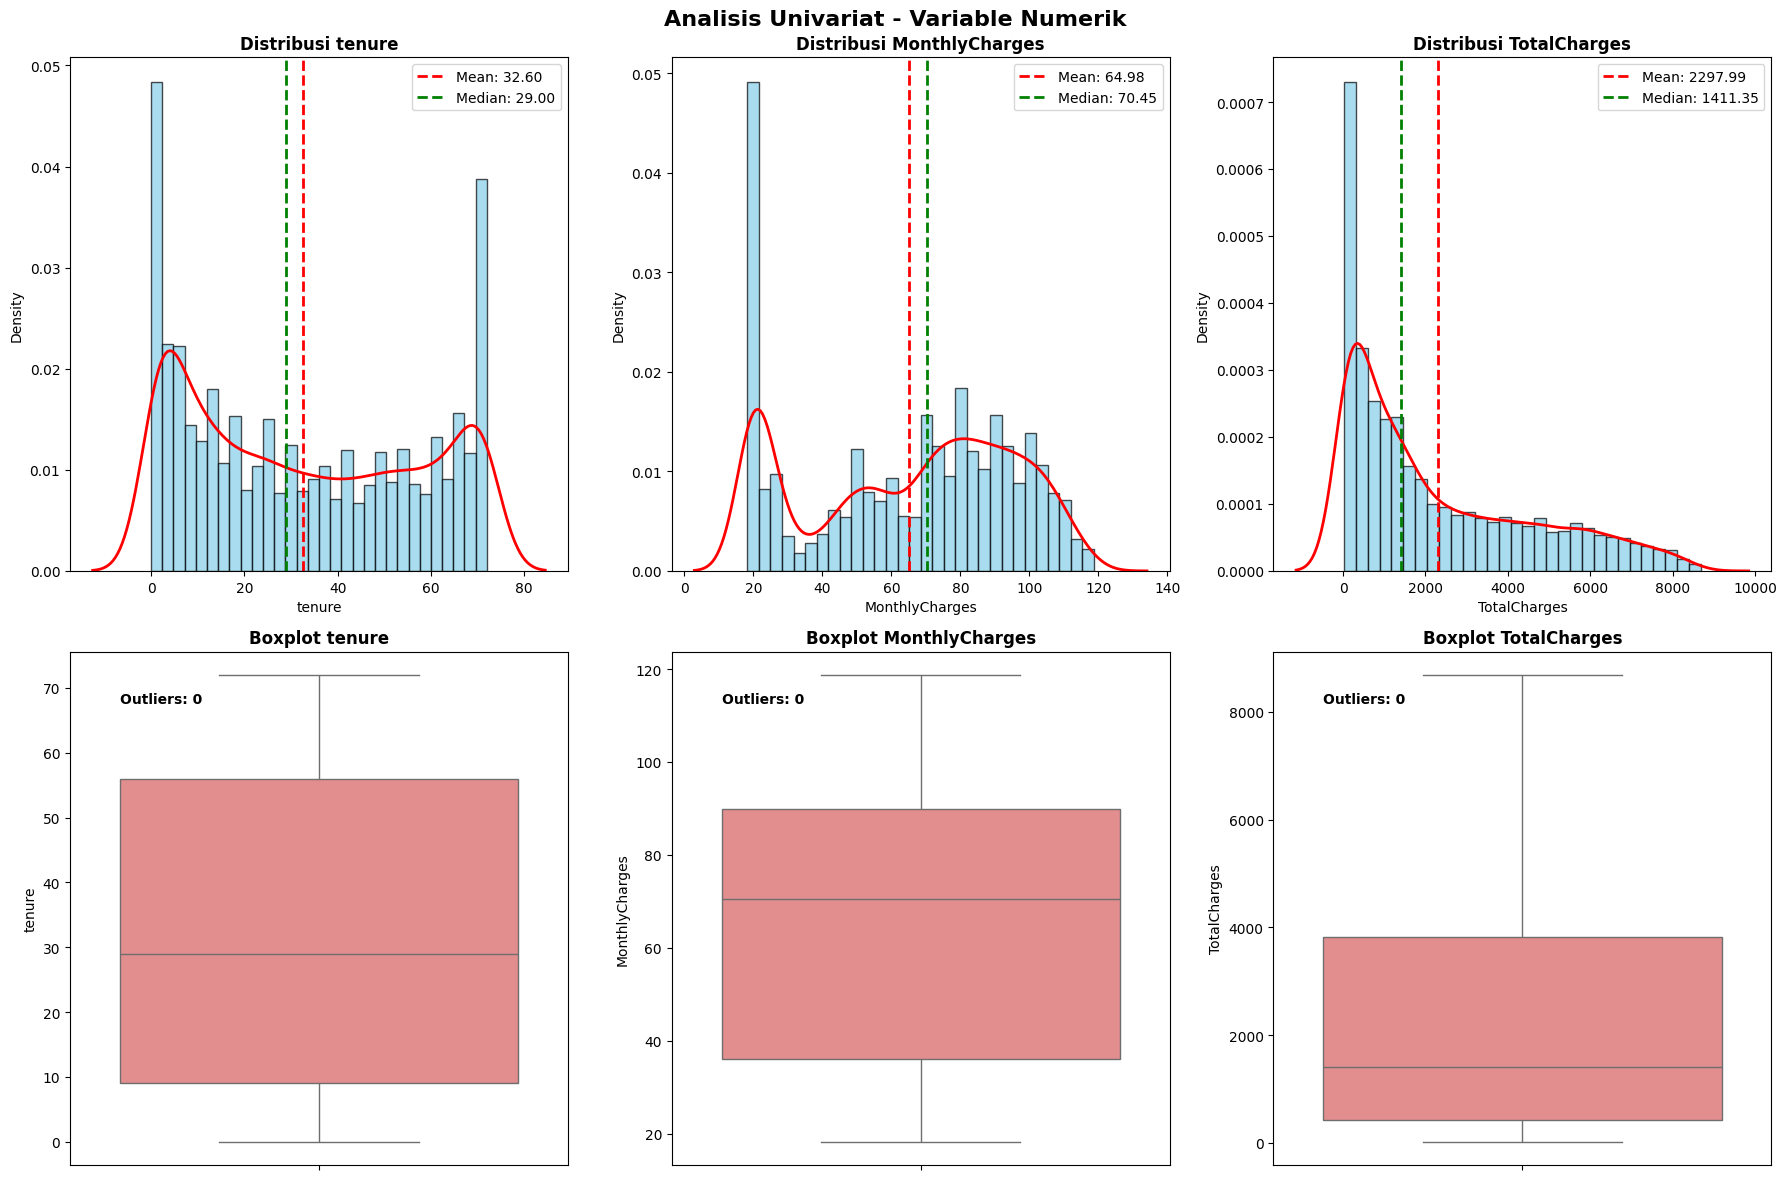

STATISTIK DESKRIPTIF VARIABEL NUMERIK:
            tenure  MonthlyCharges  TotalCharges
count  6993.000000     6993.000000   6993.000000
mean     32.595453       64.983248   2297.991159
std      24.502926       30.032765   2265.334719
min       0.000000       18.250000     18.800000
25%       9.000000       36.000000    416.300000
50%      29.000000       70.450000   1411.350000
75%      56.000000       89.950000   3815.400000
max      72.000000      118.750000   8684.800000

SKEWNESS (Kemencengan):
tenure: 0.230 (Simetris)
MonthlyCharges: -0.230 (Simetris)
TotalCharges: 0.956 (Moderat)


In [17]:
# Analisis Univariat untuk variable numerik

# set style untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")

def univariate_numeric_analysis(df):

  # pilih variable numeric
  numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

  # Buat figure dengan subplots
  fig, axes = plt.subplots(2, 3, figsize=(18, 12))
  fig.suptitle('Analisis Univariat - Variable Numerik', fontsize=16, fontweight='bold')

  for i, var in enumerate(numeric_vars):
      # histogram dengan KDE
      axes[0, i].hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
      sns.kdeplot(df[var], ax=axes[0, i], color='red', linewidth=2)
      axes[0, i].set_title(f'Distribusi {var}', fontweight='bold')
      axes[0, i].set_xlabel(var)
      axes[0, i].set_ylabel('Density')

      # Tambahkan garis vertikal untuk mean dan median
      mean_val = df_final[var].mean()
      median_val = df_final[var].median()
      axes[0, i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
      axes[0, i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
      axes[0, i].legend()

      # Boxplot
      sns.boxplot(y=df[var], ax=axes[1, i], color='lightcoral')
      axes[1, i].set_title(f'Boxplot {var}', fontweight='bold')
      axes[1, i].set_ylabel(var)

      # Tambahkan annotasi untuk outliers pada boxplot
      q1 = df[var].quantile(0.25)
      q3 = df[var].quantile(0.75)
      iqr = q3 - q1
      upper_bound = q3 + 1.5 * iqr
      outliers = df[df[var] > upper_bound][var]
      axes[1, i].text(0.1, 0.9, f'Outliers: {len(outliers)}',
                      transform=axes[1, i].transAxes, fontweight='bold')

  plt.tight_layout()
  plt.show()

  # Tampilkan statistik deskriptif
  print("STATISTIK DESKRIPTIF VARIABEL NUMERIK:")
  print("=" * 50)
  numeric_stats = df[numeric_vars].describe()
  print(numeric_stats)

  # Tampilkan skewness
  print("\nSKEWNESS (Kemencengan):")
  print("=" * 30)
  for var in numeric_vars:
    skewness = df[var].skew()
    interpretation = "Simetris" if abs(skewness) < 0.5 else "Moderat" if abs(skewness) < 1 else "Ekstrem"
    print(f"{var}: {skewness:.3f} ({interpretation})")

# jalankan analisis numerik
univariate_numeric_analysis(df_final)


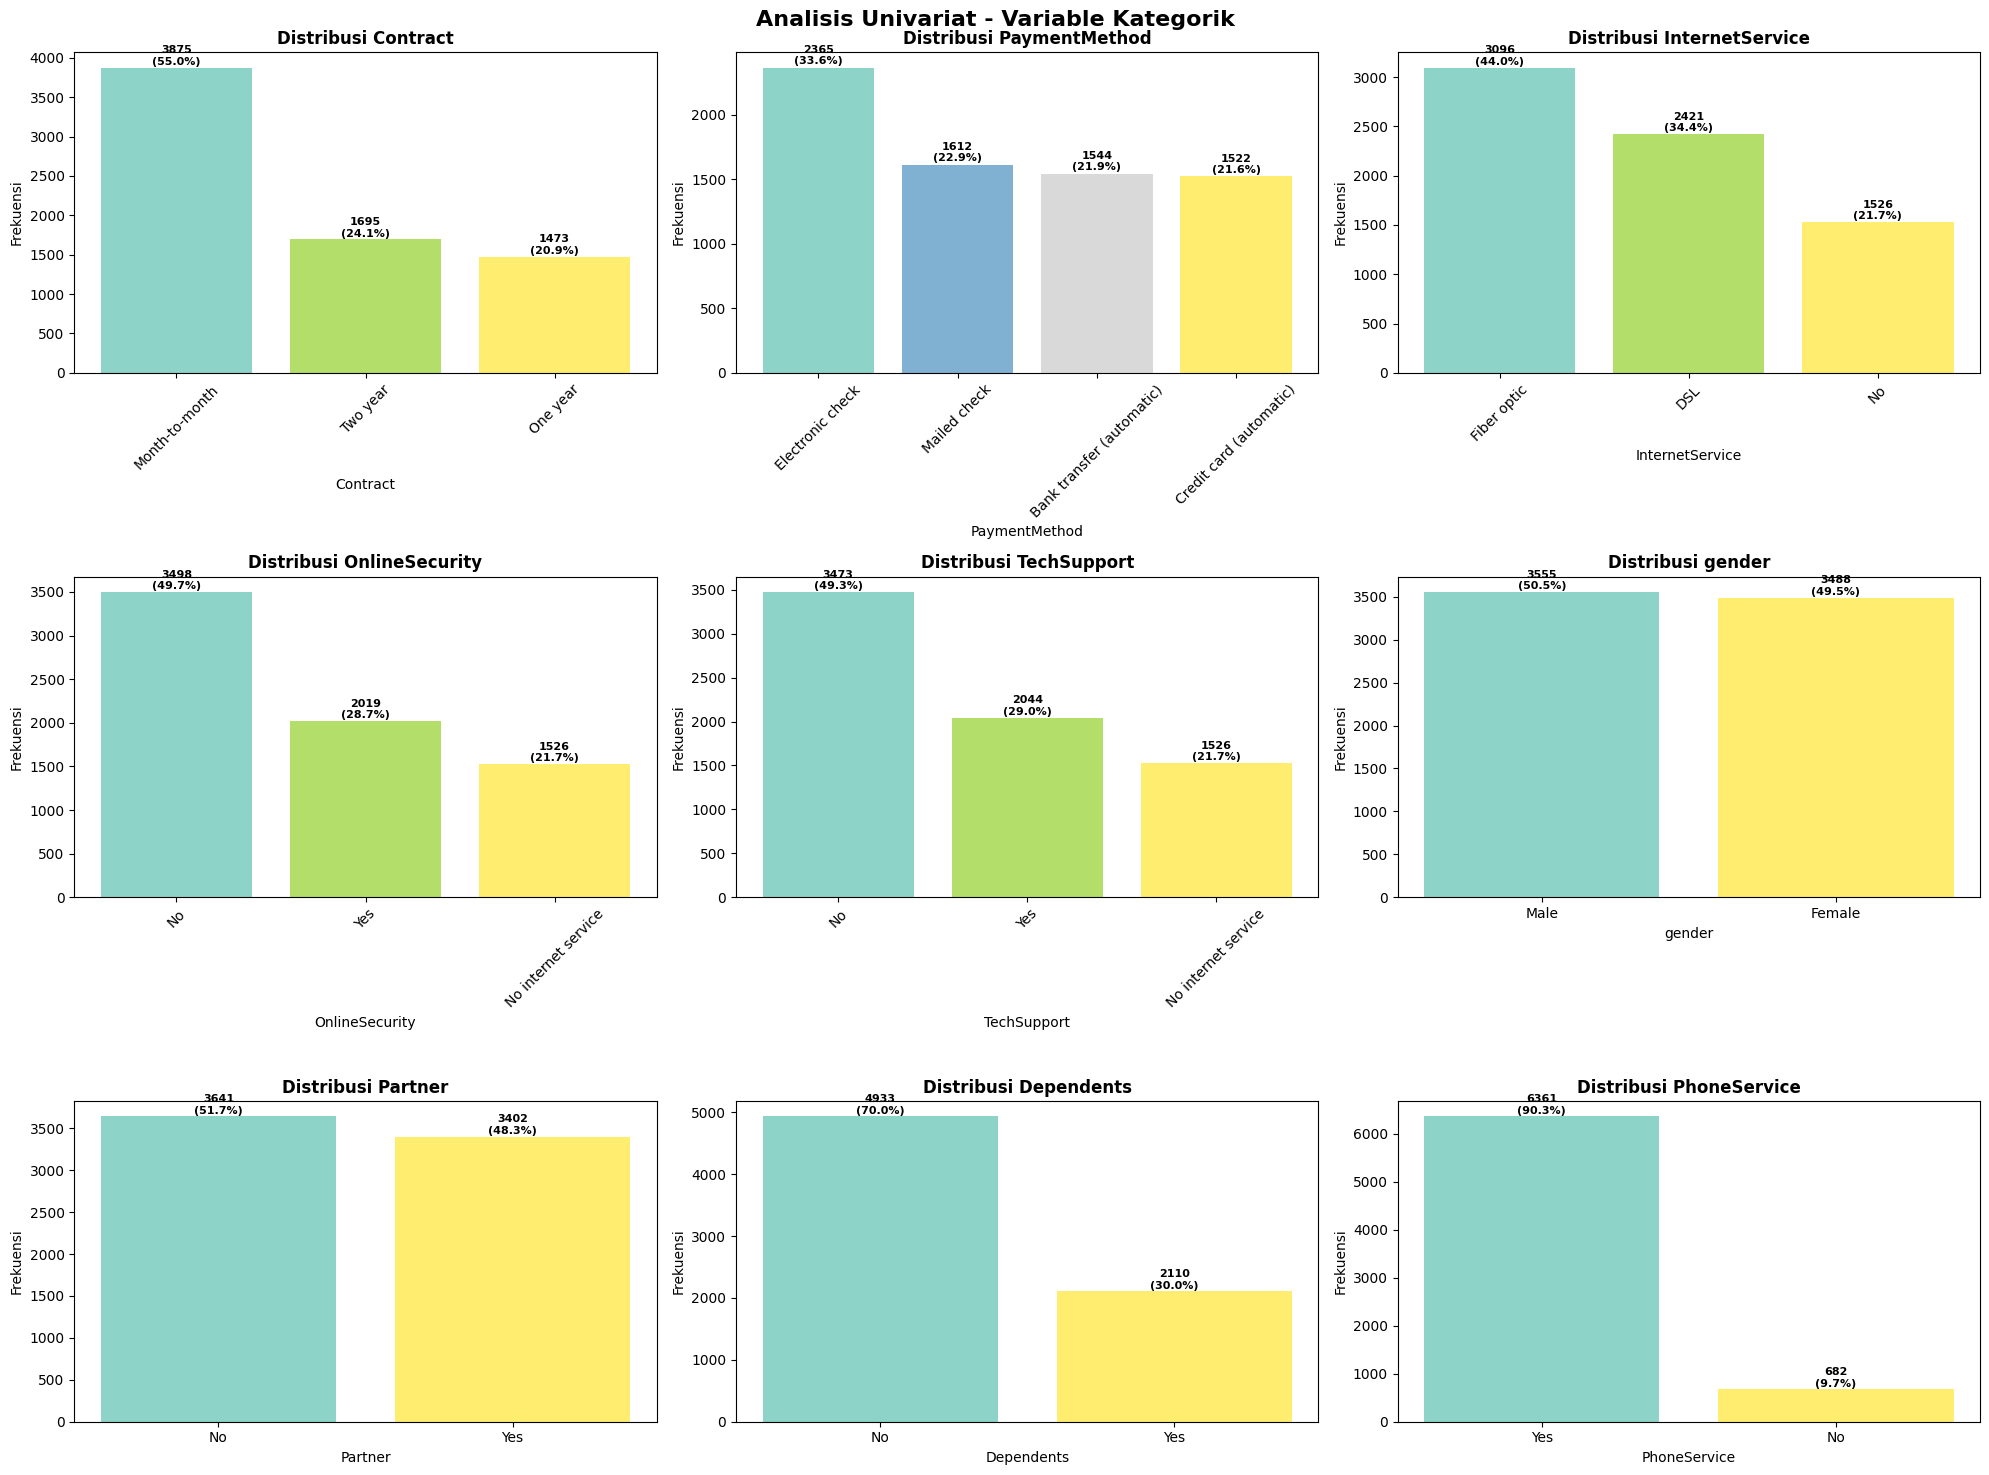

In [18]:
def univariate_categorical_analysis(df):

  # Pilih variable kategorik penting
  categorical_vars = ['Contract', 'PaymentMethod', 'InternetService',
                       'OnlineSecurity', 'TechSupport', 'gender',
                       'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

  # Buat figure untuk bar plots
  fig, axes = plt.subplots(3, 3, figsize=(20, 15))
  fig.suptitle('Analisis Univariat - Variable Kategorik', fontsize=16, fontweight='bold')

  axes = axes.ravel() # Flatten the 2x3 array untuk iterasi mudah

  for i, var in enumerate(categorical_vars):
    if i < len(axes):
      # Hitung frekuensi dan persentase
      value_counts = df[var].value_counts()
      percentages = (value_counts / len(df) * 100).round(1)

      # Buat bar plot
      bars = axes[i].bar(value_counts.index, value_counts.values,
                         color=plt.cm.Set3(np.linspace(0, 1, len(value_counts))))
      axes[i].set_title(f'Distribusi {var}', fontweight='bold')
      axes[i].set_xlabel(var)
      axes[i].set_ylabel('Frekuensi')

      if len(value_counts.index) > 2:
          axes[i].tick_params(axis='x', rotation=45)

      for j, (count, pct) in enumerate(zip(value_counts.values, percentages.values)):
          axes[i].text(j, count + 10, f'{count}\n({pct}%)',
                       ha='center', va='bottom', fontweight='bold', fontsize=8)
  # sembunyikan subplot yang tidak terpakai
  for i in range(len(categorical_vars), len(axes)):
      axes[i].set_visible(False)

  plt.tight_layout()
  plt.show()

# jalankan analisis kategorik
univariate_categorical_analysis(df)

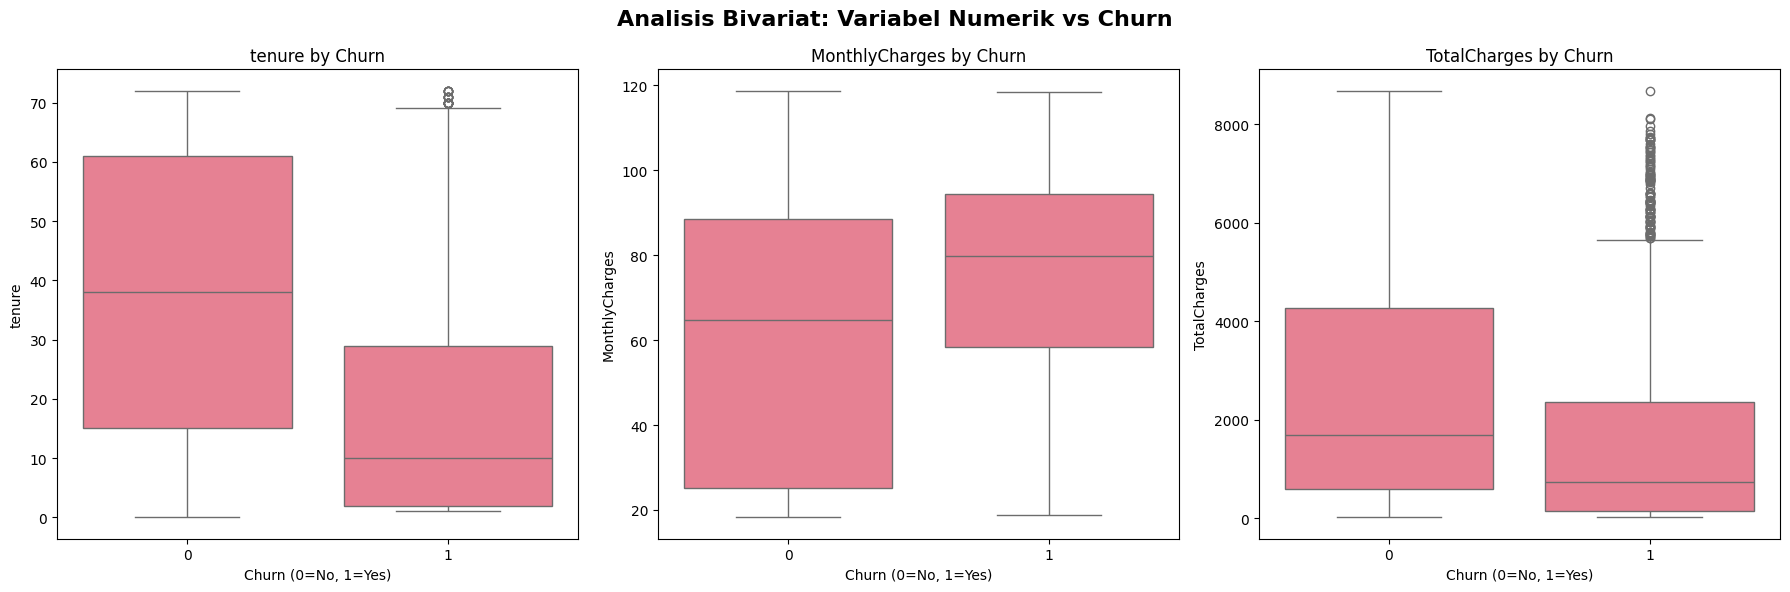

In [19]:
def bivariate_analysis_churn(df_encoded):
    """
    Analisis bivariate antara fitur numerik dengan Churn
    """
    numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Analisis Bivariat: Variabel Numerik vs Churn', fontsize=16, fontweight='bold')

    for i, var in enumerate(numeric_vars):
        # Boxplot by Churn
        sns.boxplot(x='Churn', y=var, data=df_encoded, ax=axes[i])
        axes[i].set_title(f'{var} by Churn')
        axes[i].set_xlabel('Churn (0=No, 1=Yes)')
        axes[i].set_ylabel(var)

    plt.tight_layout()
    plt.show()

# Gunakan df_final untuk analisis bivariate
bivariate_analysis_churn(df_final)

=== STACKED BAR CHART - PROPORSI CHURN ===


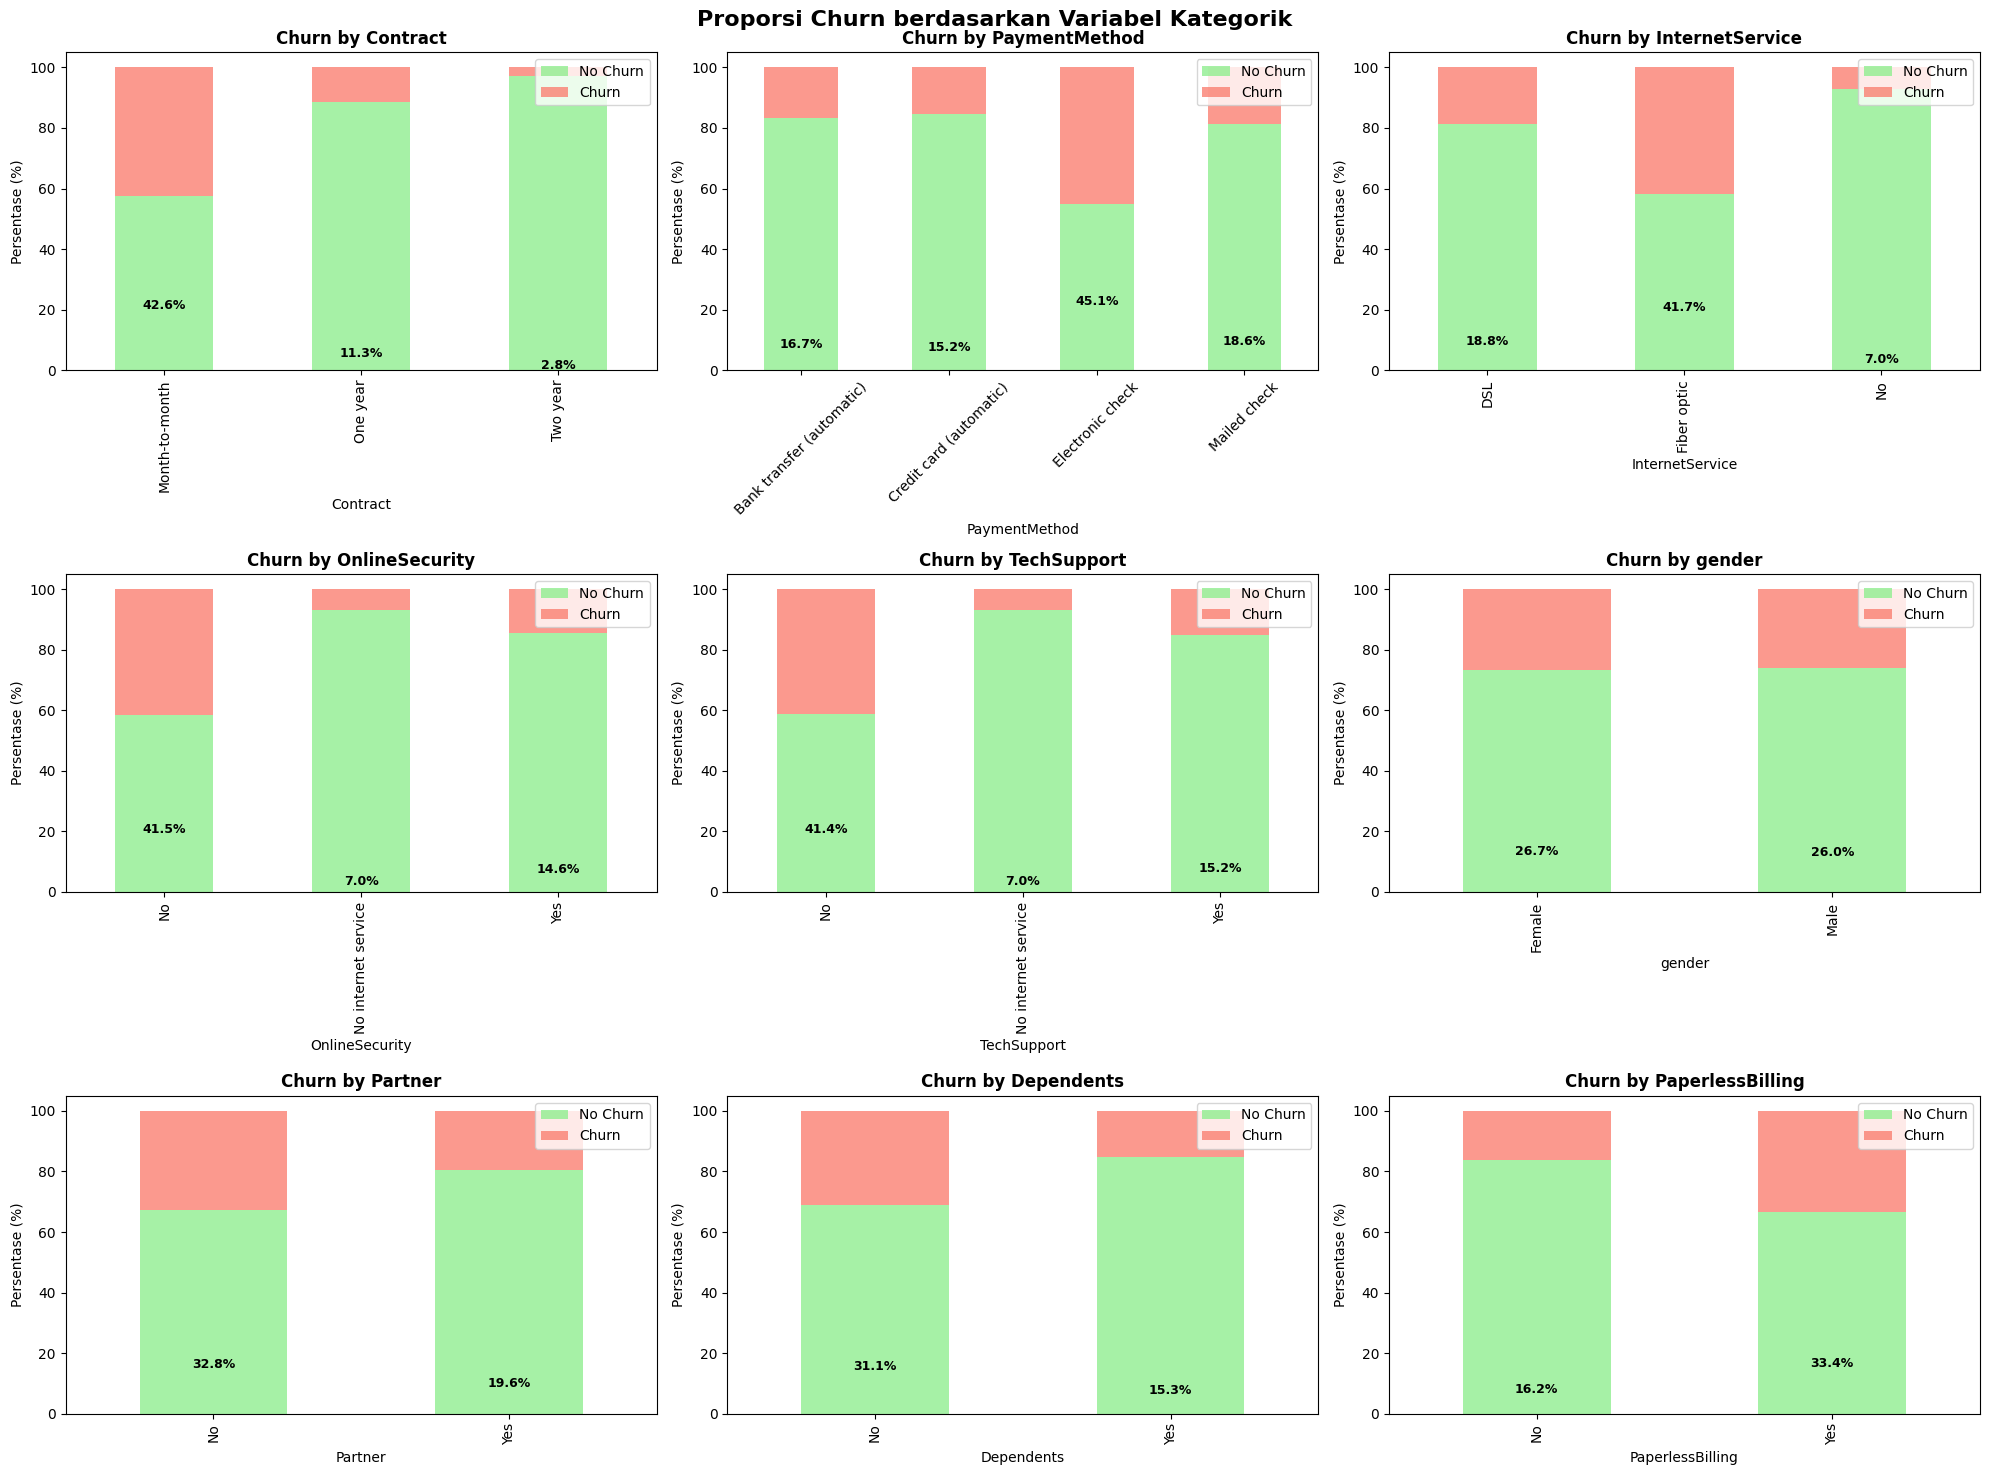


=== HEATMAP CHURN RATE ===


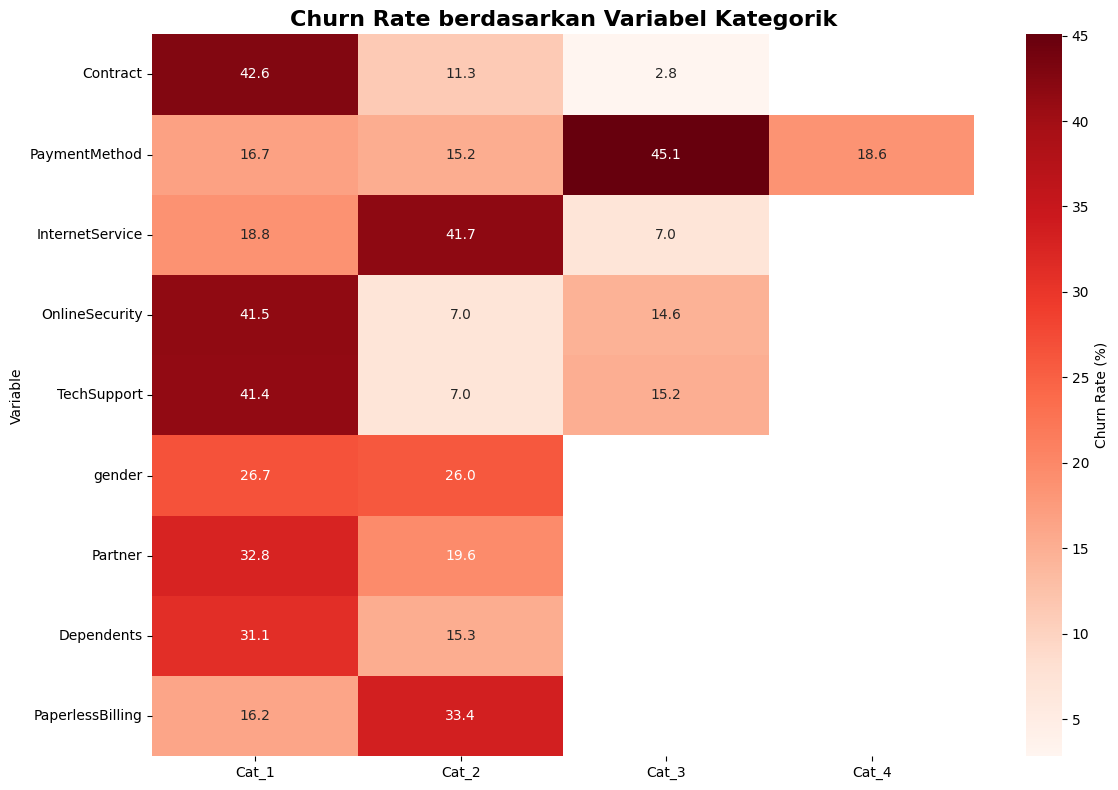


=== POINT PLOT - CHURN RATE DENGAN CONFIDENCE INTERVAL ===


/tmp/ipython-input-2398055642.py:94: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(data=df_viz, x=var, y='Churn', order=order,
/tmp/ipython-input-2398055642.py:94: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(data=df_viz, x=var, y='Churn', order=order,
/tmp/ipython-input-2398055642.py:94: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(data=df_viz, x=var, y='Churn', order=order,
/tmp/ipython-input-2398055642.py:94: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(data=df_viz, x=var, y='Churn', order=order,
/tmp/ipython-input-2398055642.py:94: FutureWarning: 

The `errwidth` parameter i

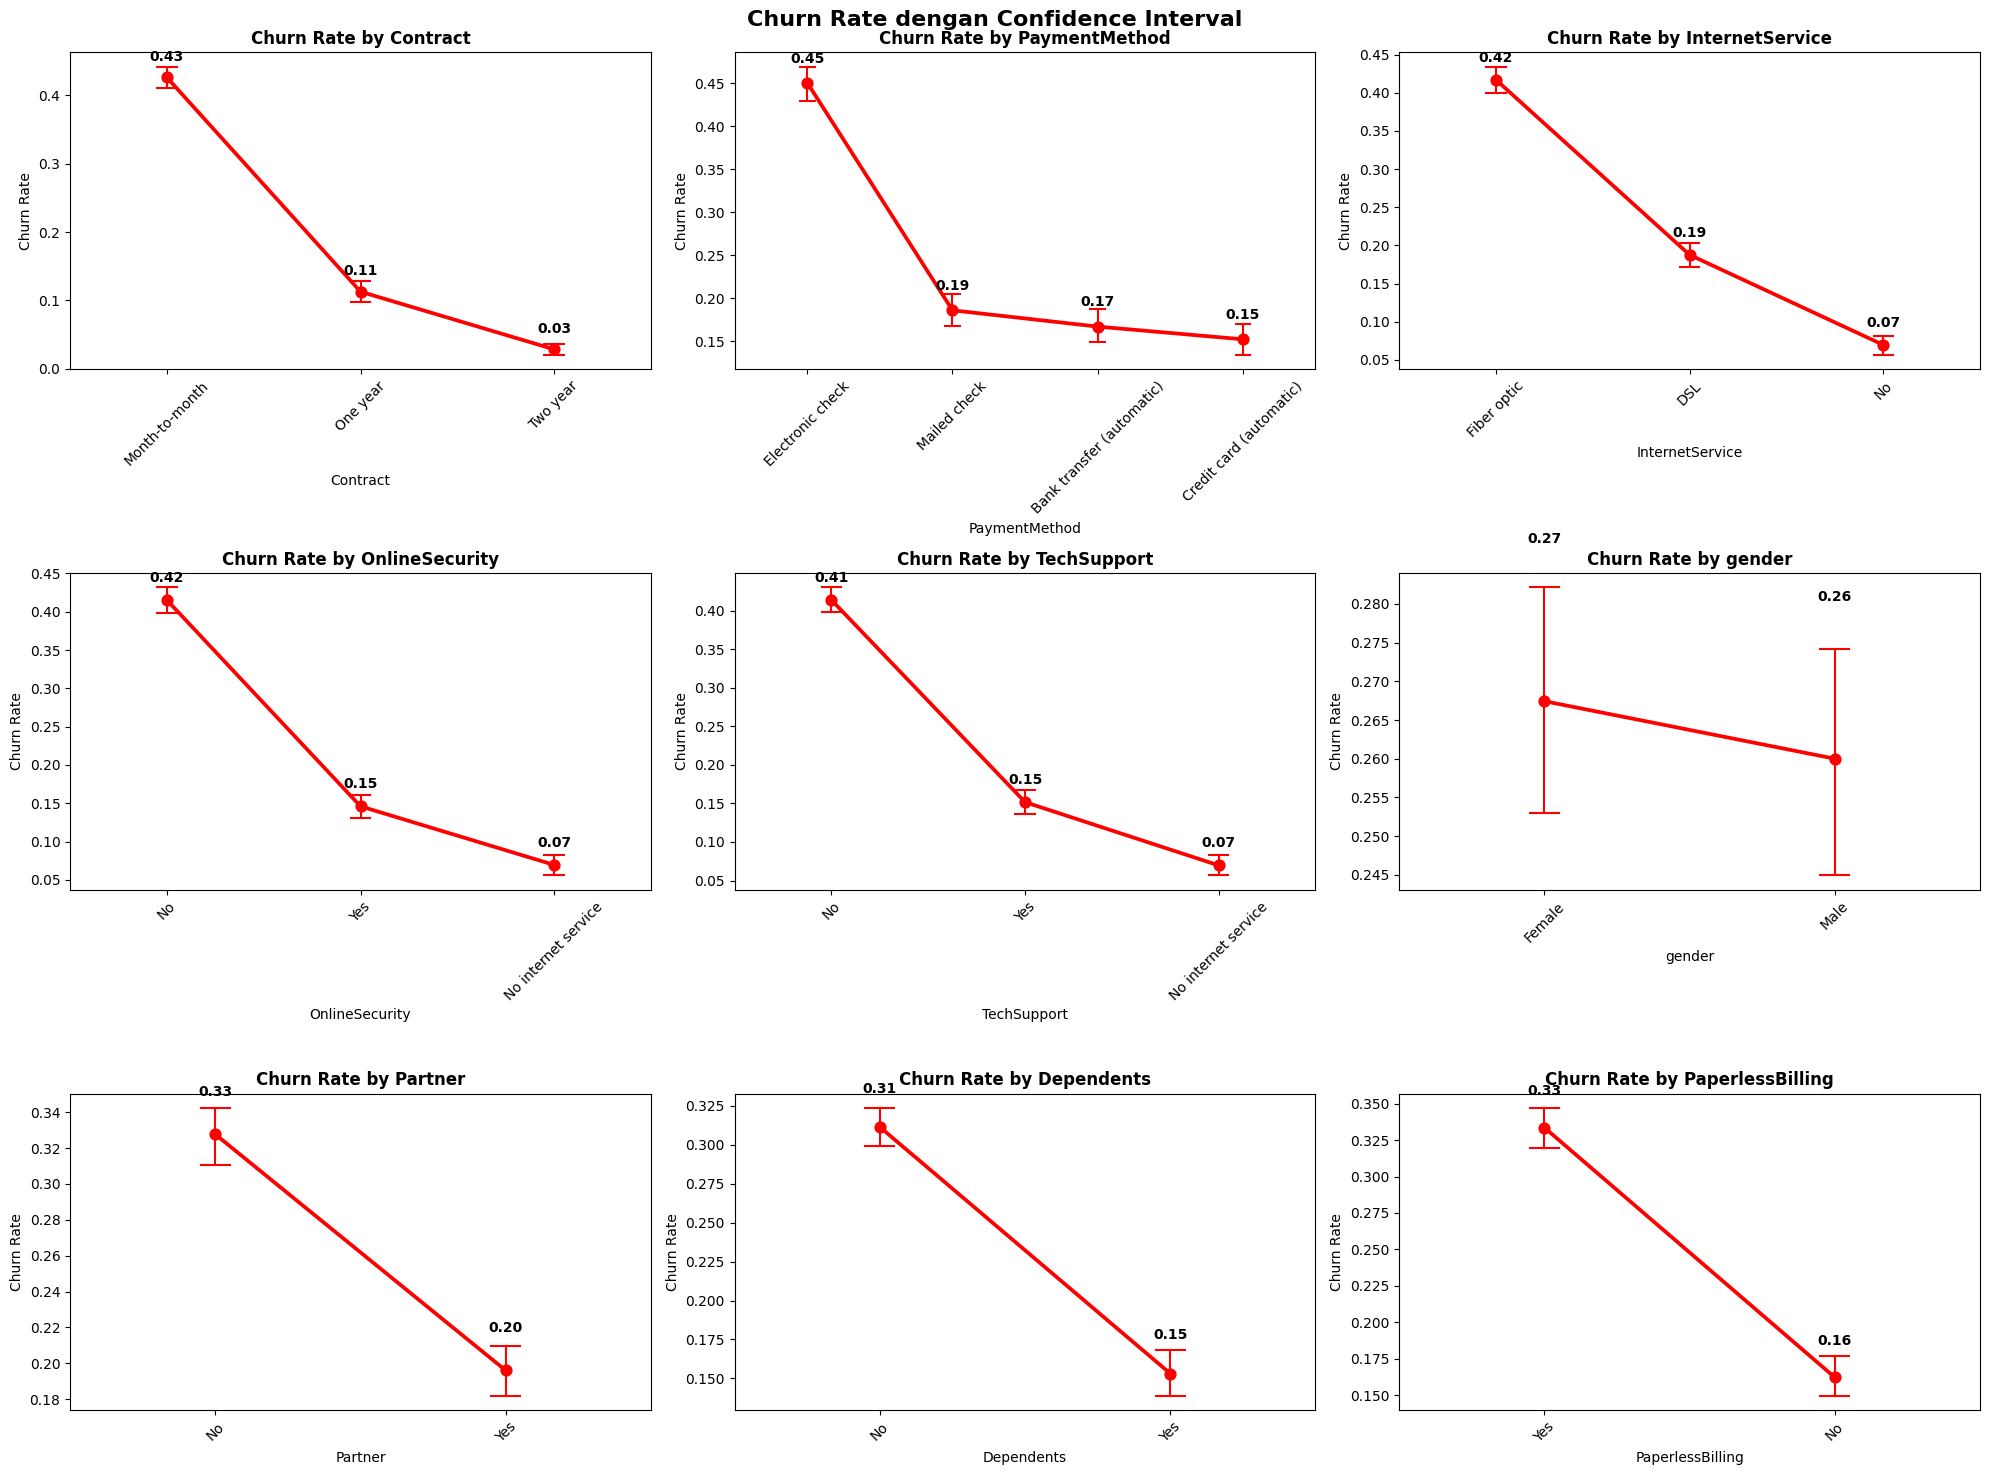


=== STATISTICAL SUMMARY ===
Churn Rate berdasarkan Kategori:

Contract:
------------------------------
                Total  Churn_Rate  Churn_Count
Contract                                      
Month-to-month   3825        42.6       1630.0
One year         1473        11.3        166.0
Two year         1695         2.8         48.0

PaymentMethod:
------------------------------
                           Total  Churn_Rate  Churn_Count
PaymentMethod                                            
Electronic check            2354        45.1       1061.0
Mailed check                1574        18.6        293.0
Bank transfer (automatic)   1543        16.7        258.0
Credit card (automatic)     1522        15.2        232.0

InternetService:
------------------------------
                 Total  Churn_Rate  Churn_Count
InternetService                                
Fiber optic       3086        41.7       1287.0
DSL               2414        18.8        453.0
No                1493   

In [20]:
def categorical_churn_analysis(df_original, df_encoded):
    """
    Analisis hubungan variabel kategorikal dengan churn
    df_original: dataset asli (untuk label kategorik)
    df_encoded: dataset yang sudah diencode (untuk churn numerik)
    """
    # Gabungkan churn dari df_encoded dengan variabel kategorik dari df_original
    df_viz = df_original.copy()
    df_viz['Churn'] = df_encoded['Churn']  # Churn sudah numerik 0/1

    # Pilih variabel kategorik penting untuk dianalisis
    categorical_vars = ['Contract', 'PaymentMethod', 'InternetService',
                       'OnlineSecurity', 'TechSupport', 'gender',
                       'Partner', 'Dependents', 'PaperlessBilling']

    # PLOT 1: Stacked Bar Chart (Proporsi Churn per Kategori)
    print("=== STACKED BAR CHART - PROPORSI CHURN ===")
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Proporsi Churn berdasarkan Variabel Kategorik', fontsize=16, fontweight='bold')

    axes = axes.ravel()

    for i, var in enumerate(categorical_vars):
        if i < len(axes):
            # Hitung cross tabulation
            cross_tab = pd.crosstab(df_viz[var], df_viz['Churn'], normalize='index') * 100

            # Plot stacked bar
            cross_tab.plot(kind='bar', ax=axes[i], stacked=True,
                          color=['lightgreen', 'salmon'], alpha=0.8)

            axes[i].set_title(f'Churn by {var}', fontweight='bold')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Persentase (%)')
            axes[i].legend(['No Churn', 'Churn'], loc='upper right')

            # Rotasi label x jika panjang
            if len(cross_tab.index) > 3:
                axes[i].tick_params(axis='x', rotation=45)

            # Tambahkan annotasi persentase
            for n, (idx, row) in enumerate(cross_tab.iterrows()):
                churn_pct = row[1]
                axes[i].text(n, churn_pct/2, f'{churn_pct:.1f}%',
                           ha='center', va='center', fontweight='bold', fontsize=9)

    # Sembunyikan subplot yang tidak terpakai
    for i in range(len(categorical_vars), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # PLOT 2: Heatmap Churn Rate
    print("\n=== HEATMAP CHURN RATE ===")
    # Hitung churn rate untuk setiap kategori
    churn_rates = {}
    for var in categorical_vars:
        churn_rate = df_viz.groupby(var)['Churn'].mean() * 100
        churn_rates[var] = churn_rate

    # Buat dataframe untuk heatmap
    max_categories = max(len(rates) for rates in churn_rates.values())
    heatmap_data = []

    for var in categorical_vars:
        rates = churn_rates[var]
        row = [var] + [rates.get(cat, np.nan) for cat in rates.index] + [np.nan] * (max_categories - len(rates))
        heatmap_data.append(row)

    # Buat heatmap
    plt.figure(figsize=(12, 8))
    heatmap_df = pd.DataFrame(heatmap_data, columns=['Variable'] + [f'Cat_{i+1}' for i in range(max_categories)])
    heatmap_df.set_index('Variable', inplace=True)

    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='Reds',
                cbar_kws={'label': 'Churn Rate (%)'})
    plt.title('Churn Rate berdasarkan Variabel Kategorik', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # PLOT 3: Point Plot (Churn Rate dengan Confidence Interval)
    print("\n=== POINT PLOT - CHURN RATE DENGAN CONFIDENCE INTERVAL ===")
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Churn Rate dengan Confidence Interval', fontsize=16, fontweight='bold')

    axes = axes.ravel()

    for i, var in enumerate(categorical_vars):
        if i < len(axes):
            # Urutkan berdasarkan churn rate
            order = df_viz.groupby(var)['Churn'].mean().sort_values(ascending=False).index

            sns.pointplot(data=df_viz, x=var, y='Churn', order=order,
                         ax=axes[i], capsize=0.1, errwidth=1.5, color='red')

            axes[i].set_title(f'Churn Rate by {var}', fontweight='bold')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Churn Rate')
            axes[i].tick_params(axis='x', rotation=45)

            # Tambahkan nilai di atas points
            for j, (category, rate) in enumerate(df_viz.groupby(var)['Churn'].mean().loc[order].items()):
                axes[i].text(j, rate + 0.02, f'{rate:.2f}',
                           ha='center', va='bottom', fontweight='bold')

    # Sembunyikan subplot yang tidak terpakai
    for i in range(len(categorical_vars), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # STATISTICAL SUMMARY
    print("\n=== STATISTICAL SUMMARY ===")
    print("Churn Rate berdasarkan Kategori:")
    print("=" * 60)

    for var in categorical_vars:
        print(f"\n{var}:")
        print("-" * 30)
        summary = df_viz.groupby(var).agg({
            'Churn': ['count', 'mean', 'sum']
        }).round(3)

        summary.columns = ['Total', 'Churn_Rate', 'Churn_Count']
        summary['Churn_Rate'] = (summary['Churn_Rate'] * 100).round(1)
        summary = summary.sort_values('Churn_Rate', ascending=False)

        print(summary)

# Jalankan analisis
categorical_churn_analysis(df, df_final)

=== FACET GRID - KOMBINASI VARIABEL ===


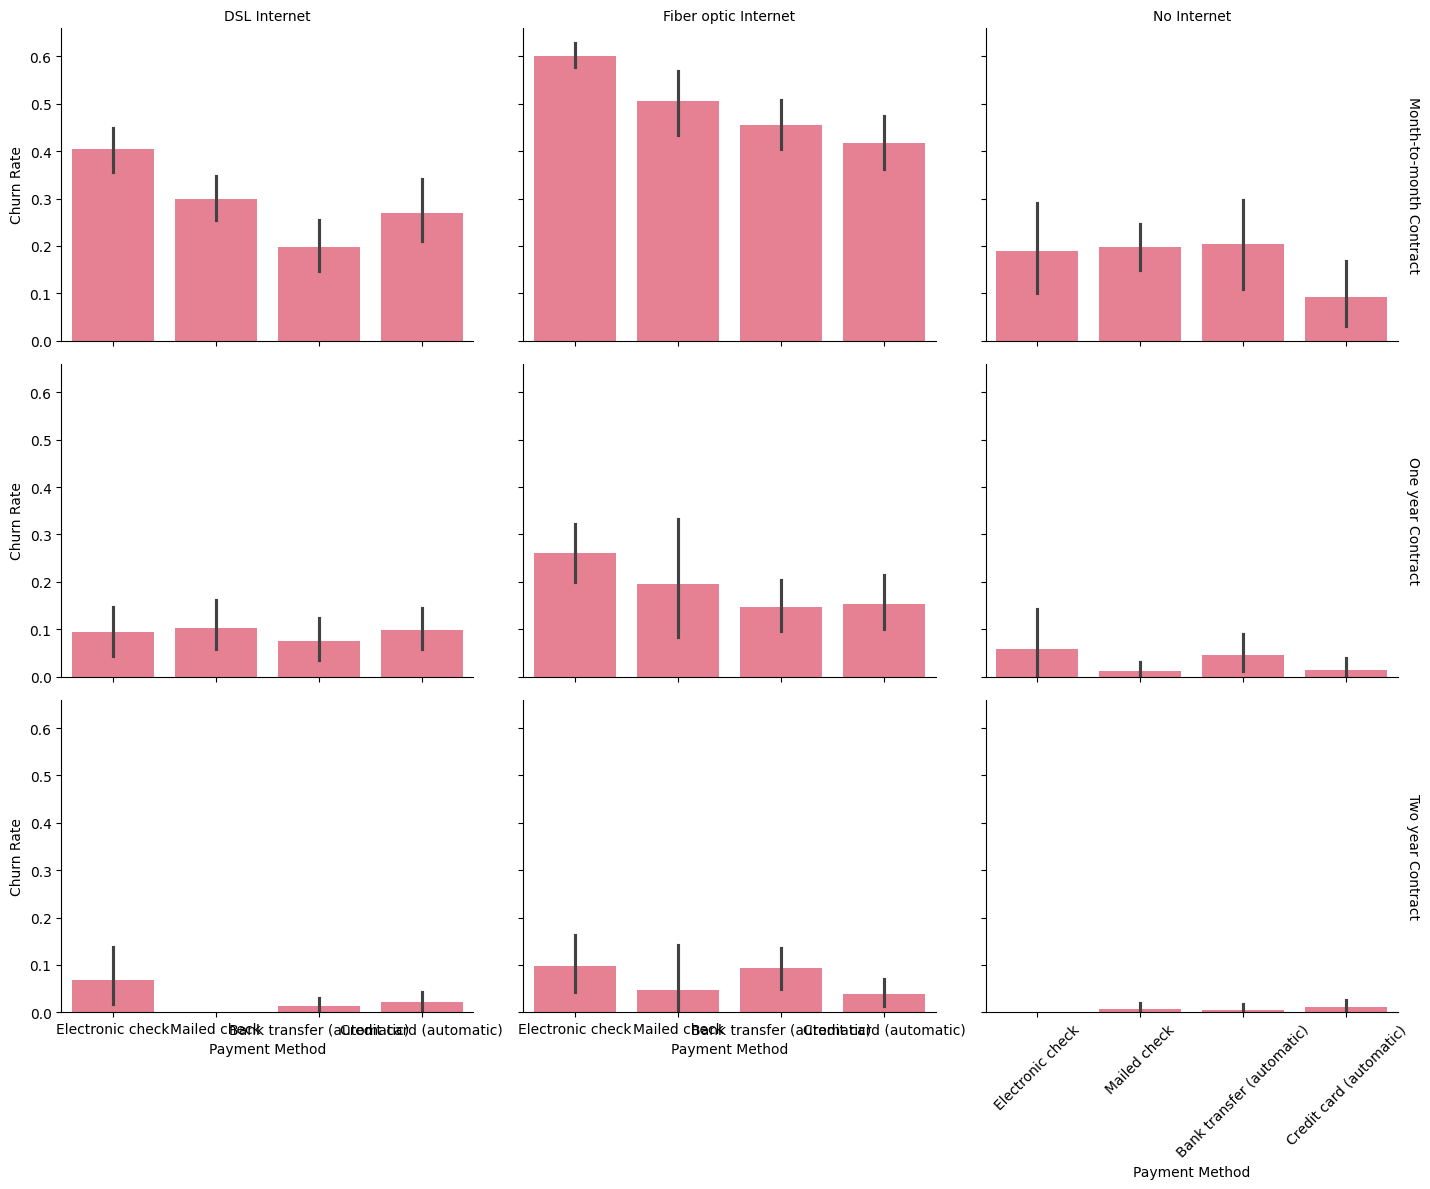


=== TOP 5 KATEGORI DENGAN CHURN RATE TERTINGGI ===


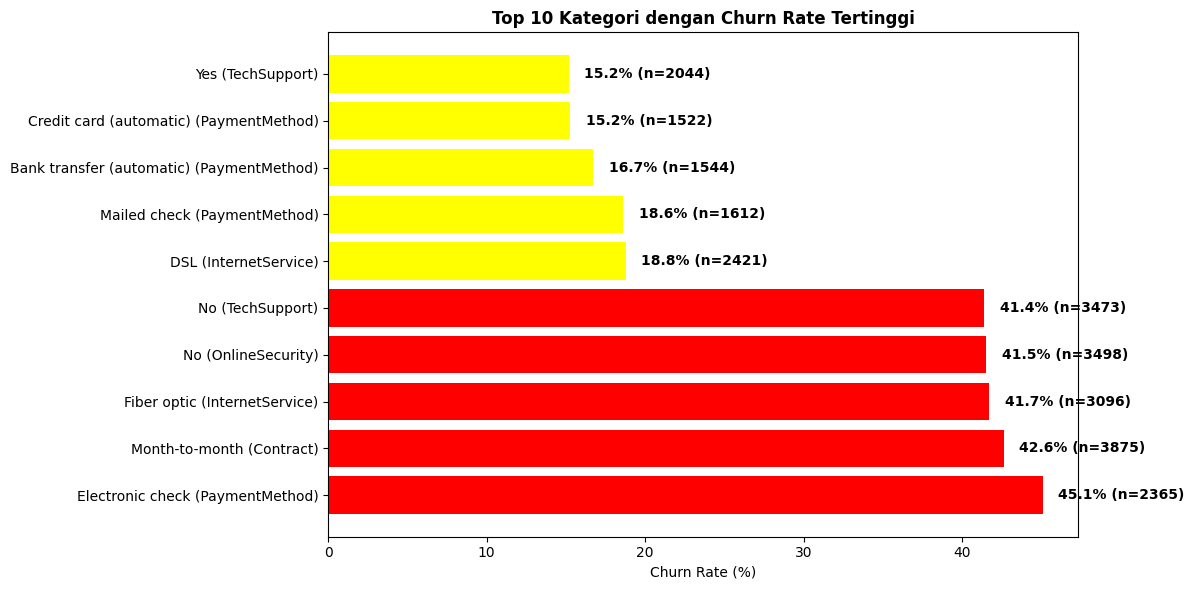


=== IMPACT ANALYSIS ===
Variabel dengan Impact Tertinggi terhadap Churn:
          Variable  Weighted_Churn_Rate  Deviation_From_Overall  Impact_Score
0         Contract               26.485                   0.115         0.115
1  InternetService               26.293                  -0.077         0.077
4      TechSupport               26.315                  -0.055         0.055
3   OnlineSecurity               26.315                  -0.054         0.054
2    PaymentMethod               26.355                  -0.014         0.014


In [21]:
def advanced_categorical_churn_analysis(df_original, df_encoded):
    """
    Analisis lanjutan hubungan kategorikal-churn dengan segmentasi
    """
    df_viz = df_original.copy()
    df_viz['Churn'] = df_encoded['Churn']

    # Focus pada variabel dengan impact tinggi
    high_impact_vars = ['Contract', 'InternetService', 'PaymentMethod',
                       'OnlineSecurity', 'TechSupport']

    # FACET GRID - Kombinasi Variabel
    print("=== FACET GRID - KOMBINASI VARIABEL ===")

    # Pilih dua variabel paling penting
    g = sns.FacetGrid(df_viz, col='InternetService', row='Contract',
                      height=4, aspect=1.2, margin_titles=True)
    g.map_dataframe(sns.barplot, x='PaymentMethod', y='Churn',
                   order=df_viz['PaymentMethod'].value_counts().index)
    g.set_axis_labels('Payment Method', 'Churn Rate')
    g.set_titles(col_template="{col_name} Internet", row_template="{row_name} Contract")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # COMPARISON PLOT - Top 5 Kategori dengan Churn Rate Tertinggi
    print("\n=== TOP 5 KATEGORI DENGAN CHURN RATE TERTINGGI ===")

    # Kumpulkan semua churn rates
    all_churn_rates = []
    for var in high_impact_vars:
        rates = df_viz.groupby(var)['Churn'].mean()
        for category, rate in rates.items():
            all_churn_rates.append({
                'Variable': var,
                'Category': category,
                'Churn_Rate': rate * 100,
                'Count': (df_viz[var] == category).sum()
            })

    churn_df = pd.DataFrame(all_churn_rates)
    top_5 = churn_df.nlargest(10, 'Churn_Rate')

    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_5)), top_5['Churn_Rate'],
                   color=['red' if x > 40 else 'orange' if x > 25 else 'yellow' for x in top_5['Churn_Rate']])

    plt.yticks(range(len(top_5)), [f"{row.Category} ({row.Variable})" for _, row in top_5.iterrows()])
    plt.xlabel('Churn Rate (%)')
    plt.title('Top 10 Kategori dengan Churn Rate Tertinggi', fontweight='bold')

    # Tambahkan nilai di bar
    for i, (rate, count) in enumerate(zip(top_5['Churn_Rate'], top_5['Count'])):
        plt.text(rate + 1, i, f'{rate:.1f}% (n={count})', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # WATERFALL ANALYSIS - Impact terhadap Overall Churn
    print("\n=== IMPACT ANALYSIS ===")

    overall_churn = df_viz['Churn'].mean() * 100
    impact_data = []

    for var in high_impact_vars:
        # Hitung weighted average churn rate
        group_rates = df_viz.groupby(var)['Churn'].mean() * 100
        group_sizes = df_viz.groupby(var).size()
        weighted_avg = (group_rates * group_sizes).sum() / group_sizes.sum()

        # Hitung deviation dari overall
        deviation = weighted_avg - overall_churn

        impact_data.append({
            'Variable': var,
            'Weighted_Churn_Rate': weighted_avg,
            'Deviation_From_Overall': deviation,
            'Impact_Score': abs(deviation) * group_sizes.sum() / len(df_viz)
        })

    impact_df = pd.DataFrame(impact_data).sort_values('Impact_Score', ascending=False)

    print("Variabel dengan Impact Tertinggi terhadap Churn:")
    print(impact_df.round(3))

# Jalankan analisis lanjutan
advanced_categorical_churn_analysis(df, df_final)

In [22]:
df_clean = df.copy()
df_clean.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Feature Engineering**

In [23]:
features = ['tenure', 'MonthlyCharges', 'TotalCharges',
            'Contract', 'InternetService', 'PaymentMethod',
            'OnlineSecurity', 'TechSupport', 'Churn']
df_clean = df_clean[features]
df_clean.head()

,tenure,MonthlyCharges,TotalCharges,Contract,InternetService,PaymentMethod,OnlineSecurity,TechSupport,Churn
0,1,29.85,29.85,Month-to-month,DSL,Electronic check,No,No,No
1,34,56.95,1889.50,One year,DSL,Mailed check,Yes,No,No
2,2,53.85,108.15,Month-to-month,DSL,Mailed check,Yes,No,Yes
3,45,42.30,1840.75,One year,DSL,Bank transfer (automatic),Yes,Yes,No
4,2,70.70,151.65,Month-to-month,Fiber optic,Electronic check,No,No,Yes


In [24]:
def final_preprocessing(df):
  df_processed = df.copy()

  # Encode variable biner
  binary_mapping = {'Yes': 1, 'No': 0}
  binary_features = ['Churn']

  for feature in binary_features:
    df_processed[feature] = df_processed[feature].map(binary_mapping)

  # Definisikan features untuk encoding
  numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
  categorical_features = ['Contract', 'InternetService', 'PaymentMethod',
                          'OnlineSecurity', 'TechSupport']

  # Buat Preprocessor
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', 'passthrough', numeric_features),
          ('cat', OneHotEncoder(drop=None, sparse_output=False), categorical_features)
      ])

  # Fit dan transform
  X = df_processed.drop('Churn', axis=1)
  y = df_processed['Churn']

  X_encoded = preprocessor.fit_transform(X)

  # Dapatkan nama kolom
  features_name = (numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

  # buat DataFrame final
  df_final = pd.DataFrame(X_encoded, columns=features_name)
  df_final['Churn'] = y.values

  return df_final, preprocessor

# gunakan fungsi
df_cleaned, preprocessor = final_preprocessing(df_clean)

print("Data final untuk modeling:")
print(f"Shape: {df_cleaned.shape}")
print(f"Tipe data Churn: {df_cleaned['Churn'].dtype}")
print(f"Unique values Churn: {df_cleaned['Churn'].unique()}")
print(f"Kolom: {df_cleaned.columns.tolist()}")
print(f"5 baris pertama:\n{df_cleaned.head()}")

Data final untuk modeling:
Shape: (7043, 20)
Tipe data Churn: int64
Unique values Churn: [0 1]
Kolom: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'Churn']
5 baris pertama:
   tenure  MonthlyCharges  TotalCharges  Contract_Month-to-month  \
0     1.0           29.85         29.85                      1.0   
1    34.0           56.95       1889.50                      0.0   
2     2.0           53.85        108.15                      1.0   
3    45.0           42.30       1840.75                      0.0   
4     2.0           70.70        151.65  

In [25]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   float64
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   Contract_Month-to-month                  7043 non-null   float64
 4   Contract_One year                        7043 non-null   float64
 5   Contract_Two year                        7043 non-null   float64
 6   InternetService_DSL                      7043 non-null   float64
 7   InternetService_Fiber optic              7043 non-null   float64
 8   InternetService_No                       7043 non-null   float64
 9   PaymentMethod_Bank transfer (automatic)  7043 non-null   float64
 10  PaymentMethod_Credit card (automatic)    7043 no

In [31]:
df_clean.head()

,tenure,MonthlyCharges,TotalCharges,Contract,InternetService,PaymentMethod,OnlineSecurity,TechSupport,Churn
0,1,29.85,29.85,Month-to-month,DSL,Electronic check,No,No,No
1,34,56.95,1889.50,One year,DSL,Mailed check,Yes,No,No
2,2,53.85,108.15,Month-to-month,DSL,Mailed check,Yes,No,Yes
3,45,42.30,1840.75,One year,DSL,Bank transfer (automatic),Yes,Yes,No
4,2,70.70,151.65,Month-to-month,Fiber optic,Electronic check,No,No,Yes


In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tenure           7043 non-null   int64  
 1   MonthlyCharges   7043 non-null   float64
 2   TotalCharges     7043 non-null   float64
 3   Contract         7043 non-null   object 
 4   InternetService  7043 non-null   object 
 5   PaymentMethod    7043 non-null   object 
 6   OnlineSecurity   7043 non-null   object 
 7   TechSupport      7043 non-null   object 
 8   Churn            7043 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB


In [37]:
df_cleaned.describe()

,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928,0.550192,0.209144,0.240664,0.343746,0.439585,0.216669,0.219225,0.216101,0.335794,0.228880,0.496663,0.216669,0.286668,0.493114,0.216669,0.290217,0.265370
std,24.559481,30.090047,2265.270398,0.497510,0.406726,0.427517,0.474991,0.496372,0.412004,0.413751,0.411613,0.472301,0.420141,0.500024,0.412004,0.452237,0.499988,0.412004,0.453895,0.441561
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,35.500000,402.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,70.350000,1397.475000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,89.850000,3786.600000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_cleaned[numeric_features] = scaler.fit_transform(df_cleaned[numeric_features])
df_cleaned.head()

,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Churn
0,-1.277445,-1.160323,-0.994242,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,0.066327,-0.259629,-0.173244,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
2,-1.236724,-0.362660,-0.959674,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1
3,0.514251,-0.746535,-0.194766,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,-1.236724,0.197365,-0.940470,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [39]:
df_cleaned.describe()

,tenure,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Churn
count,7.043000e+03,7.043000e+03,7.043000e+03,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,-1.412409e-17,-1.478490e-15,-1.427038e-15,0.550192,0.209144,0.240664,0.343746,0.439585,0.216669,0.219225,0.216101,0.335794,0.228880,0.496663,0.216669,0.286668,0.493114,0.216669,0.290217,0.265370
std,1.000071e+00,1.000071e+00,1.000071e+00,0.497510,0.406726,0.427517,0.474991,0.496372,0.412004,0.413751,0.411613,0.472301,0.420141,0.500024,0.412004,0.452237,0.499988,0.412004,0.453895,0.441561
min,-1.318165e+00,-1.545860e+00,-9.991203e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.516817e-01,-9.725399e-01,-8.298459e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.372744e-01,1.857327e-01,-3.904632e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.214551e-01,8.338335e-01,6.642871e-01,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.613701e+00,1.794352e+00,2.826743e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Modelling**

In [42]:
## Pisahkan fitur (X) dan target (y)
X = df_cleaned.drop('Churn', axis=1)
y = df_cleaned['Churn']

In [43]:
print("Distribusi kelas sebelum SMOTE:", df_cleaned['Churn'].value_counts())

Distribusi kelas sebelum SMOTE: Churn
0    5174
1    1869
Name: count, dtype: int64


In [44]:
# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Melakukan oversampling pada dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Menampilkan distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:", y_resampled.value_counts())

# Mengubah hasil menjadi DataFrame untuk visualisasi atau analisis lebih lanjut
X_resampled = pd.DataFrame(X_resampled, columns=X.columns) # Added columns to keep original names
y_resampled = pd.Series(y_resampled, name='Churn')


Distribusi kelas setelah SMOTE: Churn
0    5174
1    5174
Name: count, dtype: int64


/tmp/ipython-input-95176819.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis') # Use x-axis for 'Churn' count plot


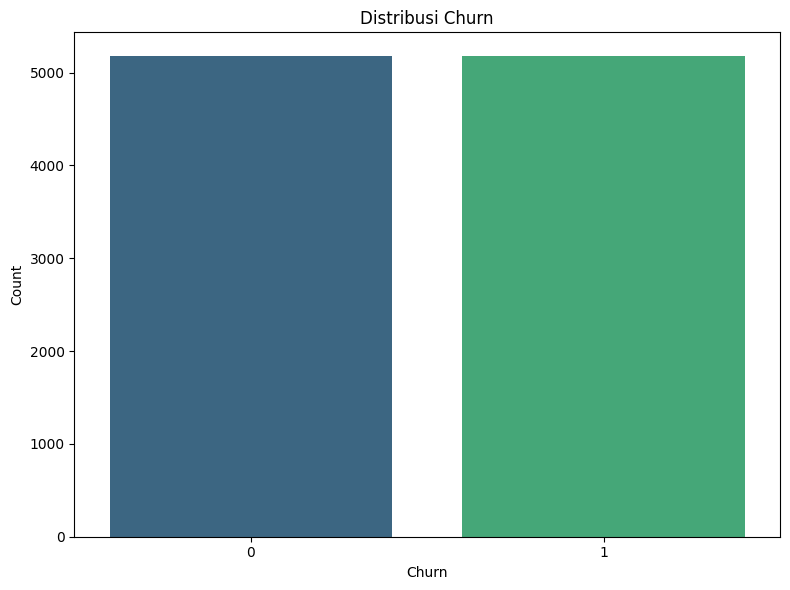

In [45]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.countplot(x=y_resampled, palette='viridis') # Use x-axis for 'Churn' count plot
plt.title('Distribusi Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [46]:
# Pisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f'Training set shape: X_train={X_train.shape}, y_train={y_train.shape}')
print(f'Test set shape: X_test={X_test.shape}, y_test={y_test.shape}')

Training set shape: X_train=(8278, 19), y_train=(8278,)
Test set shape: X_test=(2070, 19), y_test=(2070,)


In [47]:
# Random Forest
rf = RandomForestClassifier(max_depth= 14,
                            max_features= 0.5,
                            min_samples_leaf= 5,
                            min_samples_split= 10,
                            n_estimators= 100)
rf.fit(X_train, y_train)

# SVM
svm = SVC().fit(X_train, y_train)

# Logistic Regression
LR = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
LR.fit(X_train, y_train)

# XGB Classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


print('Model Selesai di Training')

Model Selesai di Training


# **Model Evaluation**

In [48]:
# fungsi untuk mengevaluasi dan mengembalikan hasil sebagai kamus
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate metrics that support multiclass
    accuracy = accuracy_score(y_test, y_pred)
    # Use average='weighted' for precision, recall, and f1-score in multiclass
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    return results

# Mengevaluasi setiap model dan mengumpulkan hasilnya
results = {
    'Random Forest (RF)': evaluate_model(rf, X_test, y_test),
    'Support Vector Machine': evaluate_model(svm, X_test, y_test),
    'Logistic Regression': evaluate_model(LR, X_test, y_test),
    'Gradient Boosting (XGB)': evaluate_model(xgb_model, X_test, y_test)
}


# Buat Dataframe untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Isi DataFrame dengan hasil
rows=[]
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Konversi daftar kamus ke DataFrame
summary_df = pd.DataFrame(rows)

# Tampilkan DataFrame
print(summary_df)

                     Model  Accuracy  Precision    Recall  F1-Score
0       Random Forest (RF)  0.833816   0.835851  0.833816  0.833450
1   Support Vector Machine  0.780193   0.781533  0.780193  0.779777
2      Logistic Regression  0.778261   0.780449  0.778261  0.777631
3  Gradient Boosting (XGB)  0.820773   0.822208  0.820773  0.820464


In [50]:
# Bandingkan dengan model lainnya
print("\n=== PERBANDINGAN SEMUA MODEL ===")
y_test_pred_lr = LR.predict(X_test)
print("Logistic Regression Test F1-Score data uji:", f1_score(y_test, y_test_pred_lr, average='weighted'))
y_train_pred_lr = LR.predict(X_train)
print("Logistic Regression Training F1-Score data train:", f1_score(y_train, y_train_pred_lr, average='weighted'))

y_test_pred_rf = rf.predict(X_test)
print("Random Forest Test F1-Score data uji:", f1_score(y_test, y_test_pred_rf, average='weighted'))
y_train_pred_rf = rf.predict(X_train)
print("Random Forest Training F1-Score data train:", f1_score(y_train, y_train_pred_rf, average='weighted'))

y_test_pred_svm = svm.predict(X_test)
print("SVM Test F1-Score:", f1_score(y_test, y_test_pred_svm, average='weighted'))
y_train_pred_svm = svm.predict(X_train)
print("SVM Training F1-Score:", f1_score(y_train, y_train_pred_svm, average='weighted'))

y_test_pred_XGB = xgb_model.predict(X_test)
print("XGB Test F1-Score:", f1_score(y_test, y_test_pred_XGB, average='weighted'))
y_train_pred_XGB = xgb_model.predict(X_train)
print("XGB Training F1-Score:", f1_score(y_train, y_train_pred_XGB, average='weighted'))

# Hitung gap overfitting untuk setiap model
lr_gap = f1_score(y_train, y_train_pred_lr, average='weighted') - f1_score(y_test, y_test_pred_lr, average='weighted')
rf_gap = f1_score(y_train, y_train_pred_rf, average='weighted') - f1_score(y_test, y_test_pred_rf, average='weighted')
svm_gap = f1_score(y_train, y_train_pred_svm, average='weighted') - f1_score(y_test, y_test_pred_svm, average='weighted')
xgb_gap = f1_score(y_train, y_train_pred_XGB, average='weighted') - f1_score(y_test, y_test_pred_XGB, average='weighted')

print("\n=== OVERFITTING GAP ANALYSIS ===")
print(f"Logistic Regression F1-Score Gap: {lr_gap:.4f}")
print(f"Random Forest F1-Score Gap: {rf_gap:.4f}")
print(f"SVM F1-Score Gap: {svm_gap:.4f}")
print(f"XGB F1-Score Gap: {xgb_gap:.4f}")


=== PERBANDINGAN SEMUA MODEL ===
Logistic Regression Test F1-Score data uji: 0.7776311169827481
Logistic Regression Training F1-Score data train: 0.7611836244396653
Random Forest Test F1-Score data uji: 0.8334504783053709
Random Forest Training F1-Score data train: 0.8850556635999225
SVM Test F1-Score: 0.7797774225694617
SVM Training F1-Score: 0.772974540678008
XGB Test F1-Score: 0.8204638160736651
XGB Training F1-Score: 0.9012126779391547

=== OVERFITTING GAP ANALYSIS ===
Logistic Regression F1-Score Gap: -0.0164
Random Forest F1-Score Gap: 0.0516
SVM F1-Score Gap: -0.0068
XGB F1-Score Gap: 0.0807


# **Hyperparameter Tuning**

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Simplified parameter space
param_distributions = {
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.05, 0.08, 0.1],
    'n_estimators': [150, 200, 250],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0.8, 1.0, 1.5]
}

xgb_model = XGBClassifier(random_state=42, objective='binary:logistic')

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions,
    n_iter=20,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running FAST RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print(f"\nBest params: {random_search.best_params_}")
print(f"Best CV F1: {random_search.best_score_:.4f}")

# Evaluate
best_model = random_search.best_estimator_
train_f1 = f1_score(y_train, best_model.predict(X_train))
test_f1 = f1_score(y_test, best_model.predict(X_test))

print(f"\nTrain F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Gap: {train_f1 - test_f1:.4f}")

Running FAST RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best params: {'subsample': 0.9, 'reg_lambda': 0.8, 'reg_alpha': 0.3, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.08, 'gamma': 0.3, 'colsample_bytree': 0.9}
Best CV F1: 0.8120

Train F1: 0.8625
Test F1: 0.8323
Gap: 0.0303
